# **Import** **Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
#import lightfm

# **Read Data and Check for Nulls**

In [12]:
train_df = pd.read_csv('Data/train.csv')
movies_df = pd.read_csv('Data/movies.csv')
imdb_df = pd.read_csv('Data/imdb_data.csv')
test_df = pd.read_csv('Data/test.csv')
links_df = pd.read_csv('Data/links.csv')
tags = pd.read_csv('Data/tags.csv')
genome_scores = pd.read_csv('Data/genome_scores.csv')
genome_tags = pd.read_csv('Data/genome_tags.csv')

In [13]:
print("Train: ")
print(str(train_df.isnull().sum()))
print("************")
print("Test: ")
print(str(test_df.isnull().sum()))
print("************")
print("Movies: ")
print(str(movies_df.isnull().sum()))
print("************")
print("Links: ")
print(str(links_df.isnull().sum()))
print("************")
print("IMDB: ")
print(str(imdb_df.isnull().sum()))
print("************")
print("Genome scores: ")
print(str(genome_scores.isnull().sum()))
print("************")
print("Genome tags: ")
print(str(genome_tags.isnull().sum()))

Train: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
************
Test: 
userId     0
movieId    0
dtype: int64
************
Movies: 
movieId    0
title      0
genres     0
dtype: int64
************
Links: 
movieId      0
imdbId       0
tmdbId     107
dtype: int64
************
IMDB: 
movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64
************
Genome scores: 
movieId      0
tagId        0
relevance    0
dtype: int64
************
Genome tags: 
tagId    0
tag      0
dtype: int64


# **Split Data**

In [ ]:
def Split_data (df, frac):

  df_splited = df.sample(frac=frac, random_state=42)
  df_splited.drop('timestamp', axis = 1, inplace = True)
  return df_splited

In [ ]:
train_splited = Split_data(train_df, .30)
print('The Splited data shape is: ' , train_splited.shape)
print('Unique users number: ', train_splited['userId'].nunique())
print('Unique Movies number: ', train_splited['movieId'].nunique())


The Splited data shape is:  (3000011, 3)
Unique users number:  160719
Unique Movies number:  33795


# **EDA (Collaborative model)**

In [ ]:
print('The number of unique users is: ', train_df['movieId'].nunique())
print('The number of unique movies is: ', train_df['userId'].nunique())
train_df.drop('timestamp', axis= 1, inplace= True)
train_df.head()

The number of unique users is:  48213
The number of unique movies is:  162541


,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [ ]:
ratings_count_users = train_df.groupby('userId')['rating'].count().reset_index()
ratings_count_users.describe()

,userId,rating
count,162541.00000,162541.000000
mean,81271.00000,61.523173
std,46921.68939,107.410889
min,1.00000,1.000000
25%,40636.00000,14.000000
50%,81271.00000,28.000000
75%,121906.00000,65.000000
max,162541.00000,12952.000000


In [ ]:
rating_count_movies = train_df.groupby('movieId')['rating'].count().reset_index()
rating_count_movies.describe()

,movieId,rating
count,48213.000000,48213.000000
mean,111418.038579,207.413727
std,66094.911931,1092.768777
min,1.000000,1.000000
25%,57637.000000,1.000000
50%,126769.000000,4.000000
75%,168208.000000,26.000000
max,209171.000000,32831.000000


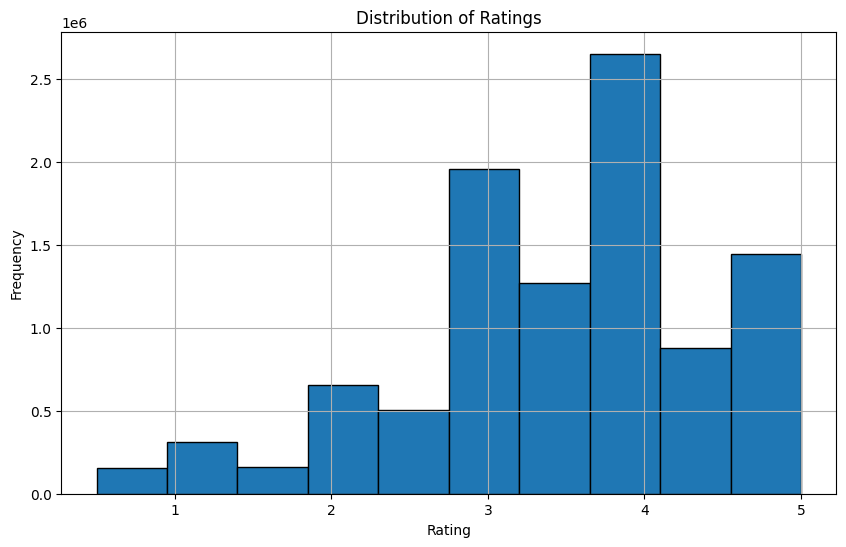

In [ ]:
# Plotting the distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(train_df['rating'], bins=10, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


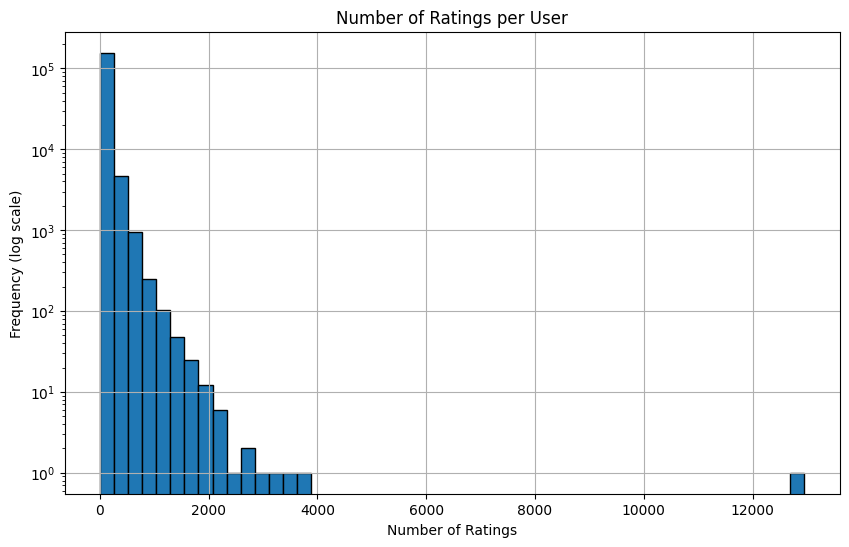

In [ ]:
# Analyzing the number of ratings per user
ratings_per_user = train_df['userId'].value_counts()

# Plotting the distribution of number of ratings per user
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, edgecolor='black')
plt.yscale('log')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()


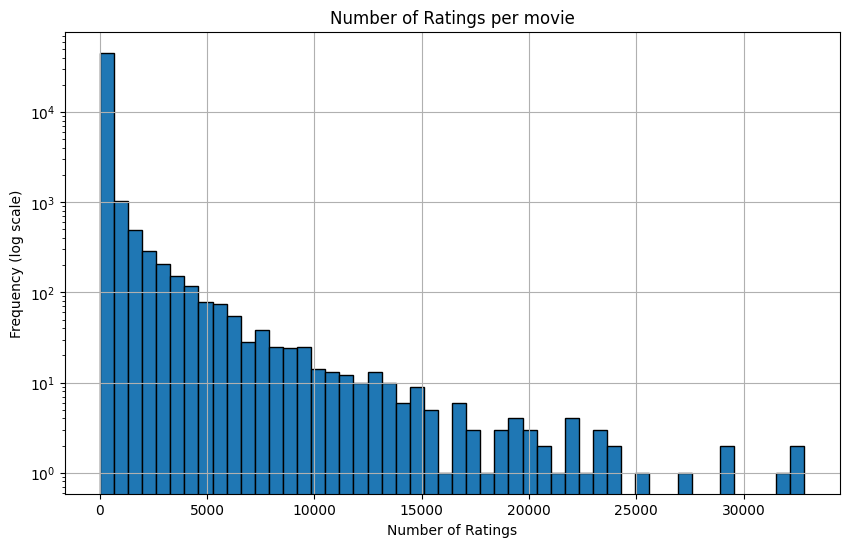

In [ ]:
# Analyzing the number of ratings per movie
ratings_per_movie = train_df['movieId'].value_counts()

# Plotting the distribution of number of ratings per user
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=50, edgecolor='black')
plt.yscale('log')
plt.title('Number of Ratings per movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()


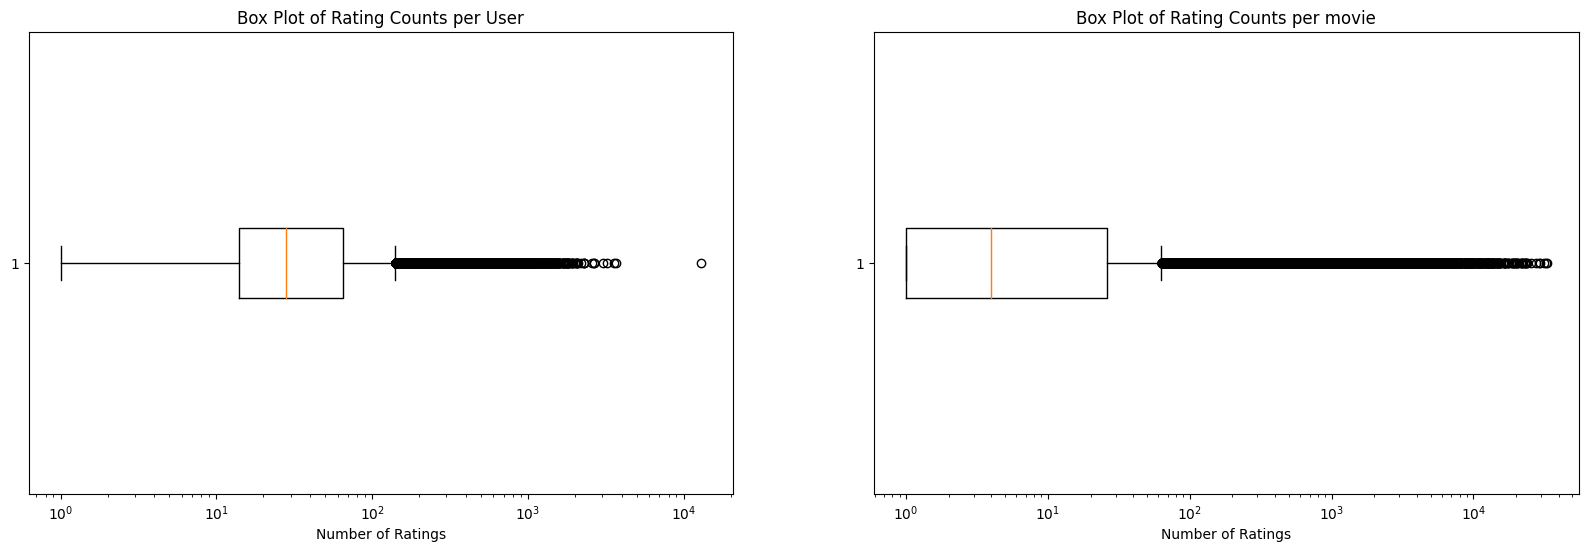

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,6))

#box Plot for rating count per user
axes[0].boxplot(ratings_count_users['rating'], vert=False)
axes[0].set_xlabel('Number of Ratings')
axes[0].set_title('Box Plot of Rating Counts per User')
axes[0].set_xscale('log')  # Use a logarithmic scale for better visualization



#box Plot for rating count per movie
axes[1].boxplot(rating_count_movies['rating'], vert=False)
axes[1].set_xlabel('Number of Ratings')
axes[1].set_title('Box Plot of Rating Counts per movie')
axes[1].set_xscale('log')  # Use a logarithmic scale for better visualization

plt.show()


In [ ]:
#filter user ID
filtered_users = ratings_count_users[ratings_count_users['rating'] >= 10]['userId']
filtered_df = train_df[train_df['userId'].isin(filtered_users)]
filtered_df.shape

(9878712, 3)

In [ ]:
#filter Movie ID
filtered_movies = rating_count_movies[rating_count_movies['rating'] >= 3]['movieId']
filtered_df = filtered_df[filtered_df['movieId'].isin(filtered_movies)]
filtered_df.shape

(9853211, 3)

In [ ]:
rating_count_movies_filtered = filtered_df.groupby('movieId')['rating'].count().reset_index()
rating_count_movies_filtered.describe()

,movieId,rating
count,29161.000000,29161.000000
mean,83197.927643,337.890024
std,65265.214481,1362.719302
min,1.000000,1.000000
25%,7582.000000,5.000000
50%,82302.000000,15.000000
75%,141104.000000,100.000000
max,208747.000000,31370.000000


In [ ]:
rating_count_users_filtered = filtered_df.groupby('userId')['rating'].count().reset_index()
rating_count_users_filtered.describe()

,userId,rating
count,146369.000000,146369.000000
mean,81336.492591,67.317608
std,46916.546818,107.794039
min,1.000000,4.000000
25%,40702.000000,17.000000
50%,81362.000000,33.000000
75%,121951.000000,72.000000
max,162541.000000,8825.000000


# **Bulid Collaborative Filtering model using SVD()**

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))
collab_df = Dataset.load_from_df(filtered_df[['userId', 'movieId', 'rating']], reader)
trainset = collab_df.build_full_trainset()

In [ ]:
'''model_svd = SVD()
model_svd.fit(trainset)'''

In [ ]:
# using gridSearch

param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(collab_df)

# Get the best model
model_svd = gs.best_estimator['rmse']

# Train the best model on the entire dataset
trainset = collab_df.build_full_trainset()
model_svd.fit(trainset)


"param_grid = {\n    'n_factors': [20, 50, 100],\n    'n_epochs': [20, 30],\n    'lr_all': [0.002, 0.005],\n    'reg_all': [0.02, 0.1]\n}\n\ngs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)\ngs.fit(collab_df)\n\n# Get the best model\nmodel_svd = gs.best_estimator['rmse']\n\n# Train the best model on the entire dataset\ntrainset = collab_df.build_full_trainset()\nmodel_svd.fit(trainset)"

In [ ]:
def predict_rating_collab (model, user_id, movie_id):
    prediction = model.predict(user_id, movie_id)
    return prediction.est


In [ ]:
#predicting rate for test set
test_df['predicted_rating'] = test_df.apply(lambda row: predict_rating_collab(model_svd, row['userId'], row['movieId']), axis=1)


In [ ]:
# Display predicted ratings
test_df.head()


,userId,movieId,predicted_rating
0,1,2011,3.545636
1,1,4144,4.133129
2,1,5767,3.668438
3,1,6711,4.145820
4,1,7318,2.332265


# **Preparing Data for submitting**

In [ ]:
def ready_for_submit (df):

  df['Id'] = df['userId'].astype(str) + '_' + df['movieId'].astype(str)

  df.drop(['userId', 'movieId'], axis= 1, inplace= True)

  df.rename(columns={'predicted_rating': 'rating'}, inplace=True)
  df = df[['Id', 'rating']]

  return df

In [ ]:
submition_df = ready_for_submit (test_df.copy())
submition_df.head()

,Id,rating
0,1_2011,3.545636
1,1_4144,4.133129
2,1_5767,3.668438
3,1_6711,4.145820
4,1_7318,2.332265


In [ ]:
submition_df.to_csv('submition_df.csv', index=False)

# **EDA (Content-Based Algorithm)**

In [ ]:
#testset shape
test_df.shape

(5000019, 2)

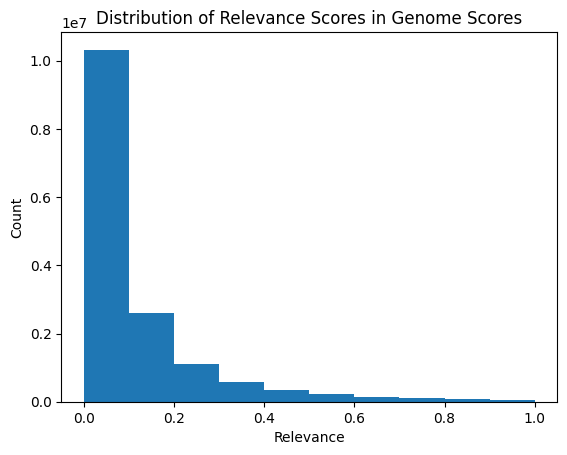

In [ ]:
plt.hist(genome_scores['relevance'], bins=10)
plt.xlabel('Relevance')
plt.ylabel('Count')
plt.title('Distribution of Relevance Scores in Genome Scores')
plt.show()


In [ ]:
g_shape_6 = genome_scores[genome_scores['relevance'] >= .5].shape[0]
g_shape = genome_scores.shape[0]
print((g_shape_6/g_shape*100))

3.9471914565084374


In [ ]:
genome_scores[genome_scores['relevance'] >= .5].shape[0]

615148

In [ ]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies_df.shape

(62423, 3)

In [ ]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


<ipython-input-15-5486ced4170a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="genres", data=movies_genres,


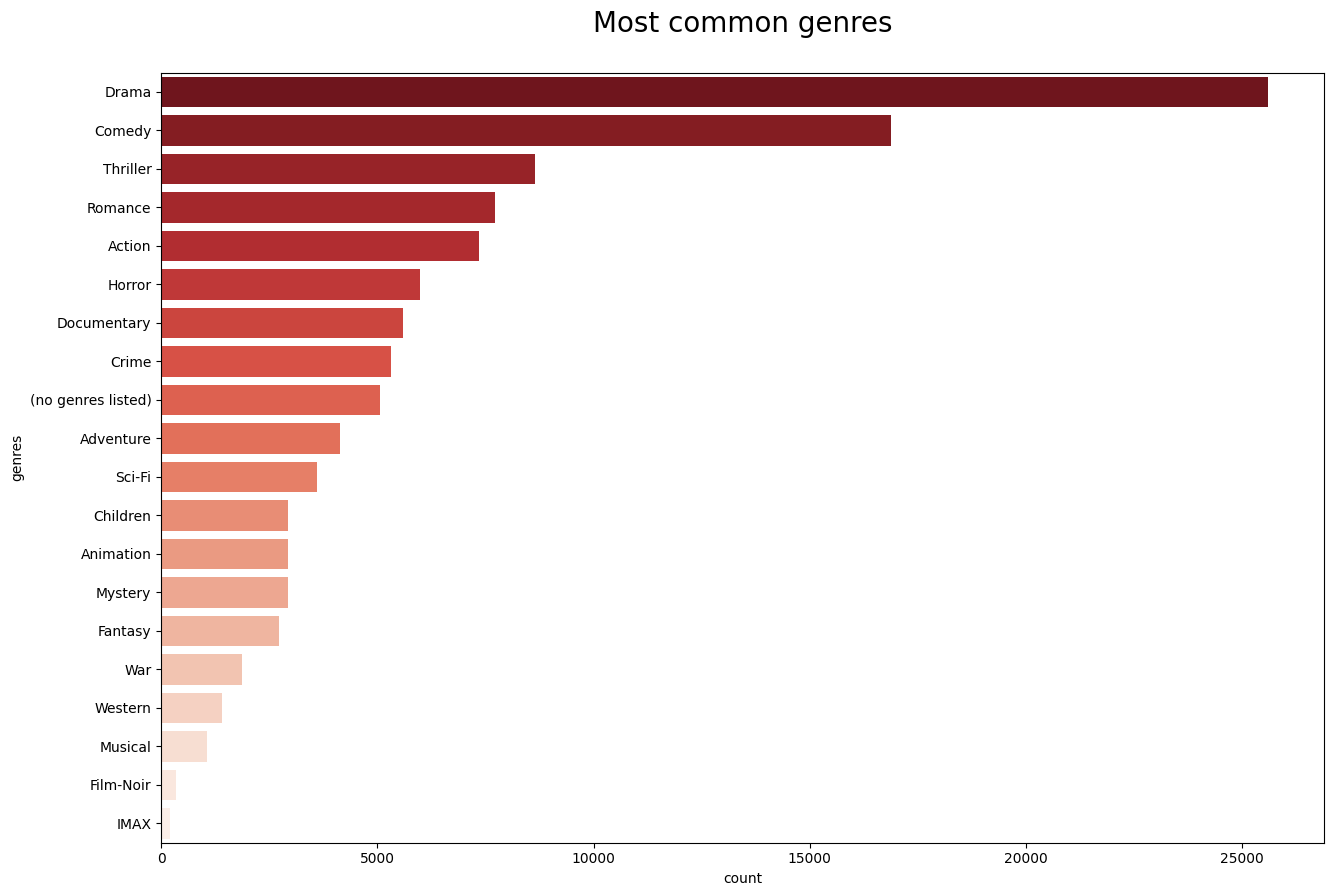

In [ ]:
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

In [ ]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


# **Preparing Data for Content-Based Algorithm**


## **- Merge train dataset with movies dataset**

In [ ]:
content_based_df = train_splited.merge(movies_df, on='movieId', how='left')
content_based_df.head()

,userId,movieId,rating,title,genres
0,122380,31445,2.5,Employee of the Month (2004),Comedy|Drama
1,22380,56775,4.0,National Treasure: Book of Secrets (2007),Action|Adventure
2,104339,356,2.5,Forrest Gump (1994),Comedy|Drama|Romance|War
3,64877,6874,4.0,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
4,63164,2762,5.0,"Sixth Sense, The (1999)",Drama|Horror|Mystery


In [ ]:
content_based_df['genres'] = content_based_df['genres'].str.replace('|', ' ')
content_based_df.head()

,userId,movieId,rating,title,genres
0,122380,31445,2.5,Employee of the Month (2004),Comedy Drama
1,22380,56775,4.0,National Treasure: Book of Secrets (2007),Action Adventure
2,104339,356,2.5,Forrest Gump (1994),Comedy Drama Romance War
3,64877,6874,4.0,Kill Bill: Vol. 1 (2003),Action Crime Thriller
4,63164,2762,5.0,"Sixth Sense, The (1999)",Drama Horror Mystery


In [ ]:
content_based_df.drop('title', axis= 1, inplace= True)
content_based_df.head()

,userId,movieId,rating,genres
0,122380,31445,2.5,Comedy Drama
1,22380,56775,4.0,Action Adventure
2,104339,356,2.5,Comedy Drama Romance War
3,64877,6874,4.0,Action Crime Thriller
4,63164,2762,5.0,Drama Horror Mystery


In [ ]:
def remove_punctuation(text):
  """
  This function removes punctuation and parentheses from a string.
  """
  # remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # remove parentheses and their contents
  text = re.sub(r'\([^)]*\)', '', text)
  return text

In [ ]:
content_based_df['genres'] = content_based_df['genres'].apply(remove_punctuation)
content_based_df.head()

,userId,movieId,rating,genres
0,122380,31445,2.5,Comedy Drama
1,22380,56775,4.0,Action Adventure
2,104339,356,2.5,Comedy Drama Romance War
3,64877,6874,4.0,Action Crime Thriller
4,63164,2762,5.0,Drama Horror Mystery


## **- Clean Tags Dataset**

In [ ]:
#preparing Tags dataset
tags.drop(['timestamp', 'userId'], axis= 1, inplace= True)
tags.head()

,movieId,tag
0,260,classic
1,260,sci-fi
2,1732,dark comedy
3,1732,great dialogue
4,7569,so bad it's good


In [ ]:
tags_aggregated = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(str(t) for t in x)).reset_index()
tags_aggregated

,movieId,tag
0,1,Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Robin Williams time travel fantasy based on ch...
2,3,funny best friend duringcreditsstinger fishing...
3,4,based on novel or book chick flick divorce int...
4,5,aging baby confidence contraception daughter g...
...,...,...
45246,208813,might like
45247,208933,black and white deal with the devil
45248,209035,computer animation Japan mass behavior mass sc...
45249,209037,chameleon computer animation gluttony humorous...


In [ ]:
tags_aggregated['tag'] = tags_aggregated['tag'].apply(remove_punctuation)
tags_aggregated.head()

,movieId,tag
0,1,Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Robin Williams time travel fantasy based on ch...
2,3,funny best friend duringcreditsstinger fishing...
3,4,based on novel or book chick flick divorce int...
4,5,aging baby confidence contraception daughter g...


### **Merge tags with content based dataset and combine genres with tags**

In [ ]:
content_based_df = content_based_df[content_based_df['genres'] != 'no genres listed']
content_based_df = content_based_df.merge(tags_aggregated, on='movieId', how='left')
content_based_df['tag'] = content_based_df['tag'].fillna('')

content_based_df['combined_features'] = content_based_df['genres'] + ' ' + content_based_df['tag']

In [ ]:
content_based_df.shape

## - **Victorize Feture**

In [ ]:
tfidf = TfidfVectorizer()
#tfidf_matrix = tfidf.fit_transform(content_based_df['genres'])

tfidf_matrix = tfidf.fit_transform(content_based_df['combined_features'])

In [ ]:
tfidf_matrix.shape

(2000008, 22)

# **Run Content-Based Model and get Predictions**

In [ ]:
#bulid a user profile for every user
def bulid_user_profile(user_data):

  user_profile = np.zeros(tfidf_matrix.shape[1])

  for index, row in user_data.iterrows():

    # Add the product of the movie's TF-IDF vector and the user's rating to the user profile
    user_profile += row['rating']* tfidf_matrix[row.name].toarray().flatten()

  # Normalize the user profile by dividing by the sum of the user's ratings
  user_profile /= user_data['rating'].sum()

  return user_profile


In [ ]:
#bulid user profile for all users
user_profiles = {}

for user_id in content_based_df['userId'].unique():
  # Filter the data for the current user
  user_data = content_based_df[content_based_df['userId'] == user_id]
  user_profiles[user_id] = bulid_user_profile(user_data)


In [ ]:
set_movie_id = set(content_based_df['movieId'])
average_rating = content_based_df['rating'].mean()

def predict_rating_content_based(user_id, movie_id):

  # Check if the movie is in the movie dataframe
  if movie_id not in set_movie_id:
       return 2.5  # Median rating or another default value

  # Get the user profile for the current user
  movie_idx = content_based_df[content_based_df['movieId'] == movie_id].index[0]

  # Get the TF-IDF vector for the current movie
  movie_tfidf = tfidf_matrix[movie_idx].toarray().flatten()
  user_profile = user_profiles.get(user_id)

  # If user profile is not found, return a default rating
  if user_profile is None:
      return 2.5  # Median rating or another default value

  similarity = cosine_similarity([user_profile], [movie_tfidf])[0][0]

  # Transform the similarity score to the rating range [0.5, 5]
  rating = 0.5 + 4.5 * ((similarity + 1) / 2)
  return rating


In [ ]:
# Predict ratings for all users and movies

predictions = {}

'''for user_id in test_df['userId'].unique():
  predictions[user_id] = {}

  for movie_id in test_df[test_df['userId'] == user_id]['movieId']:
     predictions[user_id][movie_id] = predict_rating(user_id, movie_id)'''


test_df['predicted_rating'] = test_df.apply(lambda row: predict_rating_content_based(row['userId'], row['movieId']), axis=1)


"predictions = {}\n\nfor user_id in test_df['userId'].unique():\n  predictions[user_id] = {}\n\n  for movie_id in test_df[test_df['userId'] == user_id]['movieId']:\n     predictions[user_id][movie_id] = predict_rating(user_id, movie_id)"

In [ ]:
#Display predicted ratings

test_df.head()
